# Gillespie simulation of the chemical master equation

(c) 2019 Manuel Razo. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT). 

---

In [1]:
import os
import itertools
import re
import pickle

# Our numerical workhorses
import numpy as np
import pandas as pd
import scipy as sp
import numba

# Import libraries to parallelize processes
from joblib import Parallel, delayed
import multiprocessing

# Import matplotlib stuff for plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl

# Seaborn, useful for graphics
import seaborn as sns
# Increase DPI of displayed figures
%config InlineBackend.figure_format = 'retina'

# Import the project utils
import sys
sys.path.insert(0, '../../')
import ccutils

tmpdir = '../../tmp/'
figdir = '../../fig/gillespie_simulation/'
datadir = '../../data/csv_gillespie/'

In [2]:
# Set PBoC plotting format
ccutils.viz.set_plotting_style()
# Increase dpi
mpl.rcParams['figure.dpi'] = 110

### $\LaTeX$ macros

$\newcommand{kpon}{k^p_{\text{on}}}$
$\newcommand{kpoff}{k^p_{\text{off}}}$
$\newcommand{kron}{k^r_{\text{on}}}$
$\newcommand{kroff}{k^r_{\text{off}}}$
$\newcommand{rm}{r _m}$
$\newcommand{rp}{r _p}$
$\newcommand{gm}{\gamma _m}$
$\newcommand{gp}{\gamma _p}$
$\newcommand{mm}{\left\langle m \right\rangle}$
$\newcommand{foldchange}{\text{fold-change}}$
$\newcommand{ee}[1]{\left\langle #1 \right\rangle}$
$\newcommand{bb}[1]{\mathbf{#1}}$
$\newcommand{th}[1]{\text{th}}$

### Credit

The implementation of the Gillespie algorithm in this notebook is entirely based on [Justin Bois'](http://bois.caltech.edu) tutorial that can be found [here](http://be150.caltech.edu/2017/handouts/gillespie_simulation.html).

## Gillespie simulation of the chemical master equation

As an alternative method to sample the joint mRNA protein distribution $P(m, p)$ we can use the Gillespie algorithm. This is a great alternative since the algorithm is widely used in many fields and therefore its intuitive implementation is familiar to a broad audience. Having said that, as we will show in this notebook, the algorithm can be computationally inefficient for large sample spaces since the number of computations that one has to generate to reliably sample the distribution usually grows as $N^2$ where $N$ is the sample space size.

### Propensities

The basis of the algorithm is the computation of the transition probabilities between states, In the context of the algorithm we need to compute the so-called *propensities*. These propensities dictate how likely it is for each of the possible reactions to take place. Some of the propensities have a fix value and others are updated as the chemical species change their numbers. For example, the propensity of producing an mRNA can be considered fix for a single promoter since it is just given by the mRNA production rate $r_m$, while the propensity for an mRNA to be degraded changes as the number of mRNA changes since it is given by the product of the mRNA degradation rate $\gm$ times the number of mRNAs $m$.

In order to stochastically choose which reaction $i$ will take place in the next small time window $\Delta t$ we then compute
$$
P_i = {a_i \over \sum_j a_j},
$$
where $a_i$ is the propensity of reaction $i$. In other words, the propensities are normalized by summing over all propensities of each of the possible reactions to assign a probability for each of the reactions of taking place.

### Reaction time

For a particular reaction $i$ we need to determine how long it took for this state change to take place. For a given reaction $i$ the probability that it took place in time $t$ has an exponential distribution of the form
$$
P(t \mid a_i) = a_i e^{- a_i t},
$$
since each of them are assumed to be Poission processes. That means that the probability that reaction $i$ **didn't take place** during the time window $\Delta t$ as the form
$$
P(t > \Delta t \mid a_i) = \int_{\Delta t}^\infty dt P(t \mid a_i)
= e^{- a_i \Delta t}.
$$

If we have a total of $n$ possible reactions each with propensities $a_1, a_2, \ldots, a_n$, the probability that none of them take place during the time window $\Delta t$ is given by
$$
P(t_1 > \Delta t, t_2 > \Delta t, \ldots, t_n > \Delta t) =
P(t_1 > \Delta t) \cdot P(t_2 > \Delta t) \cdots P(t_n > \Delta t),
$$
since each of these reactions are independent. Substituting these probabilities gives
$$
P(t_1 > \Delta t, t_2 > \Delta t, \ldots, t_n > \Delta t) =
\prod_i e^{-a_i \Delta t} = \exp\left[ - \Delta t \sum_i a_i \right].
$$
This is the equivalent to having a single Poisson process with rate $a = \sum_i a_i$ not arriving before time $\Delta t$. That means that the probability that any of the reactions **does arrive** during time $\Delta t$ is given by an exponential distribution with mean $\ee{t} = \left( \sum_i a_i \right)^{-1}$.

## The recipe for Gillespie's algorithm

This result leaves us with a simple recipe to implement Gillespie's algorithm:
1. Choose initial conditions for the value of the chemical species.
2. Calculate the propensity of each of the possible state changes.
3. Compute the time that it took for a reaction to take place by sampling out of an exponential distribution with mean $\ee{t} = \left( \sum_i a_i \right){-1}$.
4. Choose which reaction takes place by sampling out of the discrete distribution wit probabilities $P_i = a_i / \sum_j a_j$.
5. Update the time step by the chosen $\Delta t$.
6. Update the states according to the reaction chosed in step 4.
7. If $t$ is less than predetermined stopping time, go to step 2 and repeat.

## Test: Two-state promoter mRNA level

To test our implementation of the Gillespie algorithm we'll start with a two-state promoter producing mRNA at rate $r_m$, degrading it at rate $\gm$ and transitioning between states with rates $\kpon$ and $\kpoff$. The first thing we do is enconde the updates to the element counts.

In [3]:
# Column 0 is change in active promoter
# Column 1 is change in inactive promoter
# Column 2 is change in mRNA counts
simple_update = np.array([[1, -1, 0],  # Transition from inactive to active
                          [-1, 1, 0],  # Transition from active to inactive
                          [0, 0, 1],   # Production of mRNA
                          [0, 0, -1]], # Degradation of mRNA
                        dtype=np.int)

Now we define a function that computes the propensity of each of these reactions. Notice that we will keep the state of the promoter as a chemical species that we track. Also notice that the propensity of the mRNA production is a product of the mRNA transcription rate $r_m$ times the counts of the active promoter state. Since this count can only be either 0 or 1, this indicates that an mRNA can only be produced if the promoter is in the active state. The same is true for the propensities of the state transition since the promoter can only transition from the active state $A$ to the inactive state $I$ if it is already in the active state.

In [4]:
def simple_propensity(population, kpon, kpoff, rm, gm):
    '''
    Returns an array of the propensities given a set of parameters for a 
    two-sate promoter at the mRNA level
    
    Parameters
    ----------
    population : array-like.
        State of the molecule count for each of the species involved in the
        reaction. [active_promoter, inactive_promoter, mRNA]
    kpon, kpoff : float.
        Rates of transition between active and inactive promoter.
    rm, gm : float.
        Rate of mRNA production and degradation respectively.
        
    Returns
    -------
    propensities : array-like
        Propensities for each of the reactions.
    '''
    # Unpack population
    a_prom, i_prom, m = population
    
    return np.array([i_prom * kpon,  # Transition from inactive to active
                     a_prom * kpoff,  # Transition from active to inactive
                     a_prom * rm,  # Production of mRNA
                     gm * m]  # Degradation m RNA
                   )

### Making a draw

The Gillespie algorithm relies on generating (pseudo-)random numbers in order to decide which reaction takes place and how long it takes for such reaction to happen. Generating the time it takes is very simple using `np.random.exponential()`. For picking the reaction we could in principle use scipy's random variable sampler, but as shown in the tutorial listed at the beginning of this notebook, this is a very slow process. Therefore we will code our own discrete sampler.

In [5]:
def sample_discrete(probs):
    """
    Randomly sample an index with probability given by probs.
    """
    # Generate random number between zero and 1
    q = np.random.rand()
    
    # Find index of selected state
    i = 0
    p_sum = 0.0
    while p_sum < q:
        p_sum += probs[i]
        i += 1
    return i - 1

With this function we can choose at random one of the reactions to happen depending on the propensity values. Now we are ready to code a function that performs a single draw of our Gillespie algorithm, meaning sampling the time interval and the reaction.

In [6]:
# Function to draw time interval and choice of reaction
def gillespie_draw(propensity_func, population, args=()):
    """
    Draws a reaction and the time it took to do that reaction.
    
    Parameters
    ----------
    propensity_func : function
        Function with call signature propensity_func(population, *args)
        used for computing propensities. This function must return
        an array of propensities.
    population : ndarray
        Current population of particles
    args : tuple, default ()
        Arguments to be passed to `propensity_func`.
        
    Returns
    -------
    rxn : int
        Index of reaction that occured.
    time : float
        Time it took for the reaction to occur.
    """
    # Compute propensities
    props = propensity_func(population, *args)
    
    # Sum of propensities
    props_sum = props.sum()
    
    # Compute time
    time = np.random.exponential(1.0 / props_sum)
    
    # Compute discrete probabilities of each reaction
    rxn_probs = props / props_sum
    
    # Draw reaction from this distribution
    rxn = sample_discrete(rxn_probs)
    
    return rxn, time

## Stochastic simulation

We now have everthing ready to code up our stochastic simulation. Now we just need to define a function that uses our propensity functions, our sample draw function and updates the particle state keeping track of thte particle count.

In [7]:
def gillespie_ssa(propensity_func, update, population_0, time_points, args=()):
    """
    Uses the Gillespie stochastic simulation algorithm to sample
    from proability distribution of particle counts over time.
    
    Parameters
    ----------
    propensity_func : function
        Function of the form f(params, population) that takes the current
        population of particle counts and return an array of propensities
        for each reaction.
    update : ndarray, shape (num_reactions, num_chemical_species)
        Entry i, j gives the change in particle counts of species j
        for chemical reaction i.
    population_0 : array_like, shape (num_chemical_species)
        Array of initial populations of all chemical species.
    time_points : array_like, shape (num_time_points,)
        Array of points in time for which to sample the probability
        distribution.
    args : tuple, default ()
        The set of parameters to be passed to propensity_func.        

    Returns
    -------
    sample : ndarray, shape (num_time_points, num_chemical_species)
        Entry i, j is the count of chemical species j at time
        time_points[i].
    """

    # Initialize output
    pop_out = np.empty((len(time_points), update.shape[1]), dtype=np.int)

    # Initialize and perform simulation
    i_time = 1  # Initialize time index
    i = 0  # Initialize reaction count index
    t = time_points[0]  # Initialize time
    population = population_0.copy()  # Initialize molecule count
    pop_out[0,:] = population  # Update array of molecule count
    while i < len(time_points):
        while t < time_points[i_time]:
            # draw the event and time step
            event, dt = gillespie_draw(propensity_func, population, args)
                
            # Update the population
            population_previous = population.copy()
            population += update[event,:]
                
            # Increment time
            t += dt

        # Update the index
        i = np.searchsorted(time_points > t, True)
        
        # Update the population
        pop_out[i_time:min(i,len(time_points))] = population_previous
        
        # Increment index
        i_time = i
                           
    return pop_out

Let's now define the parameters for the two-state promoter

In [8]:
# Define mRNA rate
# http://bionumbers.hms.harvard.edu/bionumber.aspx?id=105717&ver=3&trm=lacZ%20mRNA%20lifetime&org=
gm = 1 / (3 * 60)

# Load the flat-chain
with open('../../data/mcmc/lacUV5_constitutive_mRNA_double_expo.pkl',
          'rb') as file:
    unpickler = pickle.Unpickler(file)
    gauss_flatchain = unpickler.load()
    gauss_flatlnprobability = unpickler.load()

# Generate a Pandas Data Frame with the mcmc chain
index = ['kp_on', 'kp_off', 'rm']

# Generate a data frame out of the MCMC chains
df_mcmc = pd.DataFrame(gauss_flatchain, columns=index)

# rerbsine the index with the new entries
index = df_mcmc.columns

# map value of the parameters
max_idx = np.argmax(gauss_flatlnprobability, axis=0)
kp_on, kp_off, rm = df_mcmc.iloc[max_idx, :] * gm

Now we have everything ready to run the simulation!

Let's pack all the necessary inputs and run 100 individual trajectories.

In [9]:
# Specify parameters for calculation
args = np.array([kp_on, kp_off, rm, gm])
time_points = np.linspace(0, 6000, 1000)
population_0 = np.array([1, 0, 0], dtype=int)
n_simulations = 100

# Seed random number generator for reproducibility
np.random.seed(42)

# Initialize output array
pops = np.empty((n_simulations, len(time_points), len(population_0)),
                dtype=int)

# Run the calculations
for i in range(n_simulations):
    pops[i,:,:] = gillespie_ssa(simple_propensity, simple_update,
                                population_0, time_points, args=args)

Having run the simulatinos let's take a look at the trajectories.

Text(0, 0.5, 'mRNA/cell')

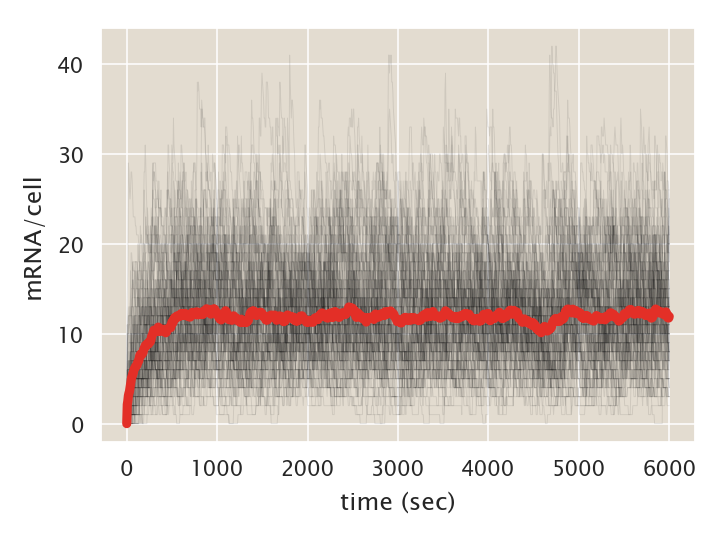

In [10]:
# Initialize plot
fig = plt.figure()

# Loop through trajectories
for i in range(n_simulations):
    plt.plot(time_points, pops[i,:,2], '-', lw=0.3, alpha=0.1,
             color='k')
    
# Plot mean mRNA
plt.plot(time_points, pops[:, :, 2].mean(axis=0), '-', lw=3,
         color=sns.color_palette('Reds_r', n_colors=2)[0])

plt.xlabel('time (sec)')
plt.ylabel('mRNA/cell')

These trajectories look reasonable. Let's try to speed up things using `numba`.

## Speeding up things with `Numba`

To run these stochastic simulations with a speed bust we'll use Python's incredibly powerful library `Numba`. This package under the hood does just-in-time (JIT) compilation of Python code, which as shown in the tutorial at the beginning of this notebook, can add up to a significant speed boost. All we have to do is decorate our functions with the command

`@numba.jit(nopython=True)`,

simple as that.

For example let's first optimize the propensity function.

In [11]:
@numba.jit(nopython=True)
def simple_propensity_numba(population, kpon, kpoff, rm, gm):
    '''
    Returns an array of the propensities given a set of parameters for a 
    two-sate promoter at the mRNA level
    
    Parameters
    ----------
    population : array-like.
        State of the molecule count for each of the species involved in the
        reaction. [active_promoter, inactive_promoter, mRNA]
    kpon, kpoff : float.
        Rates of transition between active and inactive promoter.
    rm, gm : float.
        Rate of mRNA production and degradation respectively.
        
    Returns
    -------
    propensities : array-like
        Propensities for each of the reactions.
    '''
    # Unpack population
    a_prom, i_prom, m = population
    
    return np.array([i_prom * kpon,  # Transition from inactive to active
                     a_prom * kpoff,  # Transition from active to inactive
                     a_prom * rm,  # Production of mRNA
                     gm * m]  # Degradation m RNA
                   )

# Check speeds
# Check speeds
print('Old propensity function:')
%timeit simple_propensity(population_0, *args)

print('\nNumba\'d propensity function:')
%timeit simple_propensity_numba(population_0, *args)

Old propensity function:
11.8 µs ± 22 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)

Numba'd propensity function:
2.09 µs ± 25.5 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


Factor of 5 or 6 speed up boost. Not bad. Following up the tutorial let's generate a `jit` function to perform the sum to normalize the propensities.

In [12]:
@numba.jit(nopython=True)
def sum_numba(ar):
    return ar.sum()

# Make dummy array for testing
ar = np.array([0.3, 0.4, 0.3, 0.2, 0.15])

print('\nNumPy sum:')
%timeit ar.sum()

print('\nNumba sum:')
%timeit sum_numba(ar)


NumPy sum:
2.26 µs ± 16.7 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)

Numba sum:
294 ns ± 9.39 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


This is a factor of 7 or so. Not bad at all as well. Finally, following the tutorial we will speed up the sampling of the discrete distribution in two different ways:
- First we do not need to necessaryly sample from a normalized distribution since the division to normalize propensities takes a long time. So we will do this from an unnormalized distribution.
- Second we will use `numba` again to accelerate the `while` loop.

In [13]:
@numba.jit(nopython=True)
def sample_discrete_numba(probs, probs_sum):
    q = np.random.rand() * probs_sum

    i = 0
    p_sum = 0.0
    while p_sum < q:
        p_sum += probs[i]
        i += 1
    return i - 1

# Make dummy unnormalized probs
probs = np.array([0.1, 0.3, 0.4, 0.05, 0.15, 0.6])
probs_sum = sum_numba(probs)

print('Result from hand-coded method:')
%timeit sample_discrete(probs)

print("\nResults from numba'd version:")
%timeit sample_discrete_numba(probs, probs_sum)

Result from hand-coded method:
1.54 µs ± 16.3 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)

Results from numba'd version:
336 ns ± 7.62 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


Another pretty good improvement of a factor of 5 or so!
Finally let's code a new way to draw the gillespie sample. We will feed our fast propensity function as an argument for this function.

In [16]:
def gillespie_draw_fast(propensity_func, population, args):
    """
    Draws a reaction and the time it took to do that reaction.
    """
    # Compute propensities
    props = propensity_func(population, *args)
    
    # Sum of propensities
    props_sum = sum_numba(props)
    
    # Compute time
    time = np.random.exponential(1 / props_sum)

    # Draw reaction given propensities
    rxn = sample_discrete_numba(props, props_sum)
    
    return rxn, time

print('Old Gillespie draw:')
%timeit gillespie_draw(simple_propensity, population_0, args)

print('\nFast Gillespie draw:')
%timeit gillespie_draw_fast(simple_propensity_numba, population_0, args)

Old Gillespie draw:
24.9 µs ± 1.76 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)

Fast Gillespie draw:
5.4 µs ± 22.2 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


Yet another factor of 5.

With all these improvements let's now rewrite the stochastic simulation algorithm function using our `numba`'d functions. All we will adjust here is the way that the random draws are done.

In [17]:
def gillespie_ssa_fast(propensity_func, update, population_0, 
                       time_points, args=()):
    """
    Uses the Gillespie stochastic simulation algorithm to sample
    from proability distribution of particle counts over time.
    
    Parameters
    ----------
    propensity_func : function
        Function of the form f(params, population) that takes the current
        population of particle counts and return an array of propensities
        for each reaction.
    update : ndarray, shape (num_reactions, num_chemical_species)
        Entry i, j gives the change in particle counts of species j
        for chemical reaction i.
    population_0 : array_like, shape (num_chemical_species)
        Array of initial populations of all chemical species.
    time_points : array_like, shape (num_time_points,)
        Array of points in time for which to sample the probability
        distribution.
    args : tuple, default ()
        The set of parameters to be passed to propensity_func. 
        
    Returns
    -------
    rxn : int
        Index of reaction that occured.
    time : float
        Time it took for the reaction to occur.        
    Returns
    -------
    sample : ndarray, shape (num_time_points, num_chemical_species)
        Entry i, j is the count of chemical species j at time
        time_points[i].
    """

    # Initialize output
    pop_out = np.empty((len(time_points), update.shape[1]), dtype=np.int)

    # Initialize and perform simulation
    i_time = 1
    i = 0
    t = time_points[0]
    population = population_0.copy()
    pop_out[0,:] = population
    while i < len(time_points):
        while t < time_points[i_time]:
            # draw the event and time step
            event, dt = gillespie_draw_fast(propensity_func, population, args)
                
            # Update the population
            population_previous = population.copy()
            population += update[event,:]
                
            # Increment time
            t += dt

        # Update the index
        i = np.searchsorted(time_points > t, True)
        
        # Update the population
        pop_out[i_time:min(i,len(time_points))] = population_previous
        
        # Increment index
        i_time = i
                           
    return pop_out

Let's compare both methods now to see how much our simulation was improved.

In [18]:
print('Gillespie SSA:')
%timeit gillespie_ssa(simple_propensity, simple_update, \
                      population_0, time_points, args)

print('\nFast numba Gillespie SSA:')
%timeit gillespie_ssa_fast(simple_propensity_numba, simple_update,\
                           population_0, time_points, args)

Gillespie SSA:
38.4 ms ± 1.02 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

Fast numba Gillespie SSA:
14.2 ms ± 72.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Overall we got a factor of a little more than two. That is not too bad! Our simulations will run at least twice as fast then.

Let's reproduce the previous simulation with this fast algorithm. This time we will run twice as many trajectories since our algorithm is now twice as fast.

In [20]:
# Specify parameters for calculation
args = np.array([kp_on, kp_off, rm, gm])
time_points = np.linspace(0, 6000, 1000)
population_0 = np.array([1, 0, 0], dtype=int)
n_simulations = 200

# Seed random number generator for reproducibility
np.random.seed(42)

# Initialize output array
pops = np.empty((n_simulations, len(time_points), len(population_0)),
                dtype=int)

# Run the calculations
for i in range(n_simulations):
    pops[i,:,:] = gillespie_ssa_fast(simple_propensity_numba, simple_update,
                                     population_0, time_points, args=args)

Now let's look at the results.

Text(0, 0.5, 'mRNA/cell')

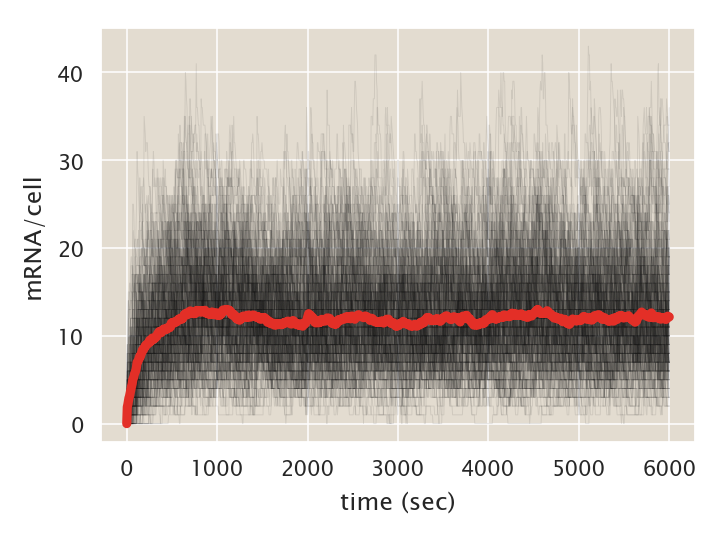

In [21]:
# Initialize plot
fig = plt.figure()

# Loop through trajectories
for i in range(n_simulations):
    plt.plot(time_points, pops[i,:,2], '-', lw=0.3, alpha=0.1,
             color='k')
    
# Plot mean mRNA
plt.plot(time_points, pops[:, :, 2].mean(axis=0), '-', lw=3,
         color=sns.color_palette('Reds_r', n_colors=2)[0])

plt.xlabel('time (sec)')
plt.ylabel('mRNA/cell')

Excellent. Everything seems to be working as expected. Now we are ready to take into account variability across the cell cycle.

### Running simulation over several cell cycles

In order to be able to compare these results with our MaxEnt approach we need to run these simulations over several cell cycles. What this implies is that we need to account for the gene copy number variability as well as the binomial partitioning of the mRNA after cell division. This is fairly simple to do, all we need to keep track of is when cells have one vs two copies of the promoter and when cells division happens.

In [22]:
def gillespie_cell_cycle(n_simulations, n_cycles, t_single, t_double,
                         args_single, args_double,
                         propensity_func, update, population_0, 
                         binom_idx=[2]):
    '''
    Parameters
    ----------
    n_simulations: int.
        Number of single trajectories to simulate.
    n_cycles : int.
        Number of cell cycles to integrate for. A cell cycle is defined
        as t_single + t_double.
    t_single : float.
        Time that cells spend with a single promoter copy
    t_double : float.
        Time that cells spend with a two promoter copies.
    args_single : tuple
        The set of parameters to be passed to propensity_func for cells with
        a single copy of the promoter.
    args_double : tuple
        The set of parameters to be passed to propensity_func for cells with
        two copies of the promoter.
    propensity_func : function
        Function of the form f(params, population) that takes the current
        population of particle counts and return an array of propensities
        for each reaction.
    update : ndarray, shape (num_reactions, num_chemical_species)
        Entry i, j gives the change in particle counts of species j
        for chemical reaction i.
    population_0 : array_like, shape (n_simulations x num_chemical_species)
        Array of initial populations of all chemical species.
    binom_idx : list, shape = population_0.shape
        Index that points at which values of the population will undergo a
        binomial partitioning to simulate each cell cycle.

    Returns
    -------
    sample : ndarray, shape (num_time_points, num_chemical_species)
        Entry i, j is the count of chemical species j at time
        time_points[i].
    '''
    # Define cell cycle length
    len_single = len(t_single)
    len_double = len(t_double)
    len_cycle = len_single + len_double
    # Initialize output array
    pops = np.empty((n_simulations, n_cycles * len_cycle, 
                     population_0.shape[1]), dtype=int)
    
    # Set initial population for each trajectory
    pop_init = population_0.copy()

    # Loop through cell cycles
    for cyc in range(n_cycles):
        # Define positions to save cell cycle
        single_pos = [cyc * len_cycle, cyc * (len_cycle) + len_single]
        double_pos = [cyc * len_cycle + len_single, 
                      (cyc + 1) * len_cycle]
        
        # Simulate single-promoter strains
        for i in range(n_simulations):
            pops[i,single_pos[0]:single_pos[1],:] = \
            gillespie_ssa_fast(propensity_func, update,
                               pop_init[i, :], t_single, args=args_single)
        # Extract last time point as initial condition for next stage
        pop_init = pops[:, single_pos[1] - 1, :]
            
        # Simulate double-promoter strains
        for i in range(n_simulations):
            pops[i,double_pos[0]:double_pos[1],:] = \
            gillespie_ssa_fast(propensity_func, update,
                               pop_init[i, :], t_double, args=args_double)
    
        # Extract last time point as inital condition for next stage
        pop_init = pops[:, double_pos[1] - 1, :]
        
        # Simulate cell division as a binomial partitioning of molecules
        for b in binom_idx:
            pop_init[:, b] = np.random.binomial(pop_init[:, b], 0.5)
            
    return pops

Having coded this function let's test it for several cell cycles. We will use the same conditions that we used with the MaxEnt approach, meaning a doubling time of 100 minutes where cells spend 60% of the time with one promoter and the rest with two promoters. The difference will be that the transcription rate $r_m$ will be doubled.

In [45]:
# Specify parameters for calculation
args_single = np.array([kp_on, kp_off, rm, gm])
args_double = np.array([kp_on, kp_off, 2 * rm, gm])

# Define doubling time
doubling_time = 100
# Define fraction of cell cycle spent with one copy
t_single_frac = 0.6
# Define time for single-promoter state
single = 60 * t_single_frac * doubling_time # sec
double = 60 * (1 - t_single_frac) * doubling_time # sec
# Specify time points for each cell cycle
t_single = np.linspace(0, single, 1000)
t_double = np.linspace(0, double, 1000)
# Define cell cycle length
len_single = len(t_single)
len_double = len(t_double)
len_cycle = len_single + len_double

# Define number of simulations
n_simulations = 100
# Initialize population for
population_0 = np.array([1, 0, 0], dtype=int)
population_0 =  np.tile(population_0, (n_simulations, 1))

# Define number of cell cycles
n_cycles = 4

# Define entire time
time_points = np.array([0])
# Define copy number index
copy_idx = list()
# Define cycle index
cycle_idx = list()
for cyc in range(n_cycles):
    # Single-promoter time values
    time_points = np.append(time_points, t_single + time_points[-1] + 
                            np.diff(t_single)[0])
    # Two-promoter time values
    time_points = np.append(time_points, t_double + time_points[-1] + 
                            np.diff(t_double)[0])
    
    # Append index for copy number
    copy_idx = copy_idx + ['single'] * len_single
    copy_idx = copy_idx + ['double'] * len_double
    
    # Append index for cell cycle number
    cycle_idx = cycle_idx + [cyc] * len_cycle

# Remove first time point that was a place holder
time_points = time_points[1:]

pops = gillespie_cell_cycle(n_simulations, n_cycles, t_single, t_double,
                    args_single, args_double,
                    simple_propensity_numba, simple_update, population_0)

Let's now arrange this messy data set into a tidy dataframe that will be much easier to handle.

In [78]:
# Extract mRNA counts
pops_mRNA = pops[:,:,2]

# Set column titles for data frame
names = ['t' + str(i) for i in range(n_simulations)]

# Convert array into data frame
df_sim_mRNA = pd.DataFrame(pops_mRNA.T, columns=names)
# Add time
df_sim_mRNA['time'] = time_points
# Add cycle number
df_sim_mRNA['cycle'] = cycle_idx
# Add promoter state
df_sim_mRNA['state'] = copy_idx

# Use pandas melt function to convert it into long format
df_sim_mRNA = df_sim_mRNA.melt(value_vars=names,
                               id_vars=['time', 'cycle', 'state'],
                               value_name='mRNA', 
                               var_name='sim_num')
# Extract promoter state
pops_prom = pops[:,:,0]
# Generate dataframe to extract melted column
df = pd.DataFrame(pops_prom.T, columns=names).melt(value_vars=names)
# Add promoter state
df_sim_mRNA['prom_state'] = df.value

df_sim_mRNA.head()

,time,cycle,state,sim_num,mRNA,prom_state
0,3.603604,0,single,t0,0,1
1,7.207207,0,single,t0,3,0
2,10.810811,0,single,t0,3,0
3,14.414414,0,single,t0,3,0
4,18.018018,0,single,t0,3,0


Excellent. Now that we have the simulations let's take a look at the time trajectories of the mRNA counts.

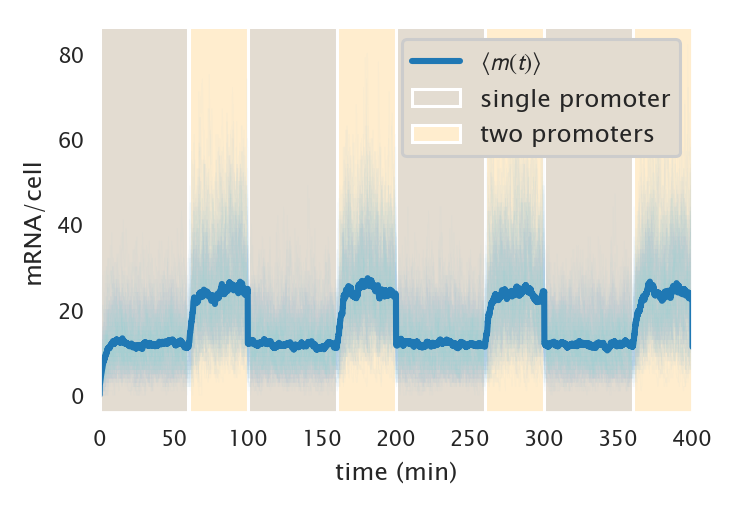

In [79]:
# Group data by simulation number
df_group = df_sim_mRNA.groupby('sim_num')

# Initialize plot
fig = plt.figure()

# Define colors
colors = sns.color_palette('Paired', n_colors=2)
# Loop through each simulation
for group, data in df_group:
    plt.plot(data.time / 60, data.mRNA, '-', lw=0.3, alpha=0.05,
             color=colors[0], label='')
    
# Compute mean mRNA
mean_mRNA =  [data.mRNA.mean() for group, data in df_sim_mRNA.groupby('time')]
# # Plot mean mRNA
plt.plot(time_points / 60, mean_mRNA, '-', lw=2,
         color=colors[1],
         label=r'$\left\langle m(t) \right\rangle$')

# Group data frame by cell cycle
df_group = df_sim_mRNA.groupby('cycle')
# Loop through cycles
for i, (group, data) in enumerate(df_group):
    # Define the label only for the last cell cycle not to repeat in legend
    if group == df_sim_mRNA['cycle'].max():
        label_s = 'single promoter'
        label_d = 'two promoters'
    else:
        label_s = ''
        label_d = ''
    # Find index for one-promoter state
    idx = np.where(data.state == 'single')[0]
    # Indicate states with two promoters
    plt.axvspan(data.iloc[idx.min()]['time'] / 60, 
               data.iloc[idx.max()]['time'] / 60,
               facecolor='#e3dcd1', label=label_s)
    
    # Find index for two-promoter state
    idx = np.where(data.state == 'double')[0]
    # Indicate states with two promoters
    plt.axvspan(data.iloc[idx.min()]['time'] / 60,
               data.iloc[idx.max()]['time'] / 60,
               facecolor='#ffedce', label=label_d)

# Set limits
plt.xlim(df_sim_mRNA['time'].min() / 60, 
            df_sim_mRNA['time'].max() / 60)
# Label plot
plt.xlabel('time (min)')
plt.ylabel('mRNA/cell')
plt.legend()

# Save figure
plt.tight_layout()
plt.savefig(figdir + 'mRNA_two_state_gillespie.pdf')

### Comparing results 

Now that we have a working simulation we are in position of comparing these results with the analytical form of the chemical master equation. Recall that for the two-state promoter at the mRNA level there was a closed-form solution to the steady-state distribution that we used in our Bayesian parameter inference to learn the values for the kinetic parameters $\kpon$, $\kpoff$, and $r_m$.

## Two-state promoter protein level